In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/N/slate/qmnguyen/projects/future-sst-prediction-diffusion


In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Lambda
from tqdm.autonotebook import tqdm

from sst.dataset import NOAA_OI_SST, Difference_NOAA_OI_SST

# Baseline Future SST Difference Prediction using Fully Connected Networks

In this notebook,
we will establish a baseline for future SST difference prediction using fully connected networks.
So no fancy diffusion models here.
We just want to know whether a very simple network can do the job or not.

## Dataset

Similar to that of [sst_unconditional_diffusion.py](./sst_unconditional_diffusion.py):

In [3]:
train_ds = NOAA_OI_SST(train=True)
train_ds = Difference_NOAA_OI_SST(train_ds)

We will want to split the data into training and validation data using 20% split:
80% for training and 20% for validation.

In [4]:
train_size = int(len(train_ds) * 0.8)
val_size = len(train_ds) - train_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
print(f'{train_size=} {len(train_ds)=}')
print(f'{val_size=} {len(val_ds)=}')

train_size=75129 len(train_ds)=75129
val_size=18783 len(val_ds)=18783


In addition, we will need test dataset for this experiment.

In [5]:
test_ds = NOAA_OI_SST(train=False)
test_diff_ds = Difference_NOAA_OI_SST(test_ds)
print(f'{len(test_ds)=}')

len(test_ds)=2892


## Fully-Connected Network

In [6]:
class BaselineSSTDifferenceModel(nn.Module):
    def __init__(self, nb_past_observations: int) -> None:
        super().__init__()

        self.flatten = nn.Flatten()
        self.hidden = nn.Sequential(
            nn.Linear(24*24*nb_past_observations, 1024), nn.LayerNorm(1024), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(1024, 2048), nn.LayerNorm(2048), nn.ReLU(), nn.Dropout(0.5),
        )
        self.output = nn.Linear(2048, 24*24)
        self.unflatten = nn.Unflatten(1, unflattened_size=(1, 24, 24))

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = self.output(x)
        x = self.unflatten(x)
        return x

### Training

In [7]:
class BaselineTrainingProcedure:
    def __init__(self, model: BaselineSSTDifferenceModel, device: str, lr: float = 1e-3) -> None:
        self._model = model.to(device)
        self._device = device

        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=lr)

    def train(self, dataloader: DataLoader, epoch: int) -> float:
        model = self._model.train()
        device = self._device
        optimizer = self._optimizer

        total_loss = 0.
        nb_batches = len(dataloader)
        for X, y in tqdm(dataloader, total=nb_batches, desc=f'Training epoch #{epoch}'):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = F.smooth_l1_loss(y_pred, y)

            total_loss += float(loss.cpu().item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return total_loss /  nb_batches

    @torch.no_grad()
    def evaluate(self, dataloader) -> float:
        model = self._model.eval()
        device = self._device

        total_loss = 0.
        nb_batches = len(dataloader)
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            # loss = F.mse_loss(y_pred, y)
            loss = F.smooth_l1_loss(y_pred, y)

            total_loss += float(loss.cpu().item())

        return total_loss / nb_batches


# Obtain training device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Training model.
model = BaselineSSTDifferenceModel(3)
train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_ds, batch_size=256, num_workers=4)

training_procedure = BaselineTrainingProcedure(model, device)
epochs = 1 if device == 'cpu' else 100
for epoch in range(epochs):
    train_loss = training_procedure.train(train_dataloader, epoch)
    val_loss = training_procedure.evaluate(val_dataloader)

    print(f'{train_loss=:.4f} {val_loss=:.4f}')

cuda


Training epoch #0:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0470 val_loss=0.0357


Training epoch #1:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0359 val_loss=0.0354


Training epoch #2:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0351 val_loss=0.0352


Training epoch #3:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0347 val_loss=0.0350


Training epoch #4:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0345 val_loss=0.0350


Training epoch #5:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0343 val_loss=0.0349


Training epoch #6:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0342 val_loss=0.0349


Training epoch #7:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0341 val_loss=0.0349


Training epoch #8:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0340 val_loss=0.0349


Training epoch #9:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0339 val_loss=0.0348


Training epoch #10:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0338 val_loss=0.0347


Training epoch #11:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0337 val_loss=0.0347


Training epoch #12:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0336 val_loss=0.0347


Training epoch #13:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0336 val_loss=0.0348


Training epoch #14:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0334 val_loss=0.0348


Training epoch #15:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0334 val_loss=0.0347


Training epoch #16:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0333 val_loss=0.0347


Training epoch #17:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0331 val_loss=0.0347


Training epoch #18:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0331 val_loss=0.0347


Training epoch #19:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0329 val_loss=0.0349


Training epoch #20:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0328 val_loss=0.0347


Training epoch #21:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0327 val_loss=0.0348


Training epoch #22:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0326 val_loss=0.0348


Training epoch #23:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0325 val_loss=0.0349


Training epoch #24:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0324 val_loss=0.0349


Training epoch #25:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0323 val_loss=0.0349


Training epoch #26:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0321 val_loss=0.0351


Training epoch #27:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0320 val_loss=0.0351


Training epoch #28:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0319 val_loss=0.0351


Training epoch #29:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0318 val_loss=0.0350


Training epoch #30:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0317 val_loss=0.0350


Training epoch #31:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0315 val_loss=0.0351


Training epoch #32:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0314 val_loss=0.0351


Training epoch #33:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0313 val_loss=0.0352


Training epoch #34:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0312 val_loss=0.0352


Training epoch #35:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0311 val_loss=0.0352


Training epoch #36:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0310 val_loss=0.0352


Training epoch #37:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0308 val_loss=0.0352


Training epoch #38:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0308 val_loss=0.0352


Training epoch #39:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0307 val_loss=0.0353


Training epoch #40:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0305 val_loss=0.0354


Training epoch #41:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0304 val_loss=0.0353


Training epoch #42:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0303 val_loss=0.0353


Training epoch #43:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0303 val_loss=0.0354


Training epoch #44:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0302 val_loss=0.0355


Training epoch #45:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0301 val_loss=0.0354


Training epoch #46:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0300 val_loss=0.0356


Training epoch #47:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0299 val_loss=0.0354


Training epoch #48:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0298 val_loss=0.0355


Training epoch #49:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0297 val_loss=0.0355


Training epoch #50:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0297 val_loss=0.0356


Training epoch #51:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0296 val_loss=0.0357


Training epoch #52:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0295 val_loss=0.0355


Training epoch #53:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0294 val_loss=0.0355


Training epoch #54:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0293 val_loss=0.0357


Training epoch #55:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0293 val_loss=0.0356


Training epoch #56:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0292 val_loss=0.0357


Training epoch #57:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0291 val_loss=0.0357


Training epoch #58:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0290 val_loss=0.0357


Training epoch #59:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0290 val_loss=0.0357


Training epoch #60:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0289 val_loss=0.0357


Training epoch #61:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0288 val_loss=0.0357


Training epoch #62:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0288 val_loss=0.0356


Training epoch #63:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0287 val_loss=0.0358


Training epoch #64:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0286 val_loss=0.0358


Training epoch #65:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0286 val_loss=0.0357


Training epoch #66:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0285 val_loss=0.0358


Training epoch #67:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0285 val_loss=0.0358


Training epoch #68:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0284 val_loss=0.0359


Training epoch #69:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0284 val_loss=0.0358


Training epoch #70:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0283 val_loss=0.0358


Training epoch #71:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0282 val_loss=0.0358


Training epoch #72:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0282 val_loss=0.0357


Training epoch #73:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0281 val_loss=0.0358


Training epoch #74:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0280 val_loss=0.0357


Training epoch #75:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0280 val_loss=0.0358


Training epoch #76:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0279 val_loss=0.0357


Training epoch #77:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0279 val_loss=0.0359


Training epoch #78:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0278 val_loss=0.0358


Training epoch #79:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0278 val_loss=0.0358


Training epoch #80:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0278 val_loss=0.0359


Training epoch #81:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0277 val_loss=0.0359


Training epoch #82:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0277 val_loss=0.0358


Training epoch #83:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0276 val_loss=0.0360


Training epoch #84:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0276 val_loss=0.0358


Training epoch #85:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0275 val_loss=0.0360


Training epoch #86:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0275 val_loss=0.0359


Training epoch #87:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0275 val_loss=0.0360


Training epoch #88:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0274 val_loss=0.0359


Training epoch #89:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0274 val_loss=0.0360


Training epoch #90:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0273 val_loss=0.0360


Training epoch #91:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0273 val_loss=0.0359


Training epoch #92:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0272 val_loss=0.0360


Training epoch #93:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0272 val_loss=0.0360


Training epoch #94:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0271 val_loss=0.0360


Training epoch #95:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0271 val_loss=0.0359


Training epoch #96:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0271 val_loss=0.0360


Training epoch #97:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0271 val_loss=0.0359


Training epoch #98:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0270 val_loss=0.0360


Training epoch #99:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0270 val_loss=0.0360


### Results

Here, we will display some prediction results.

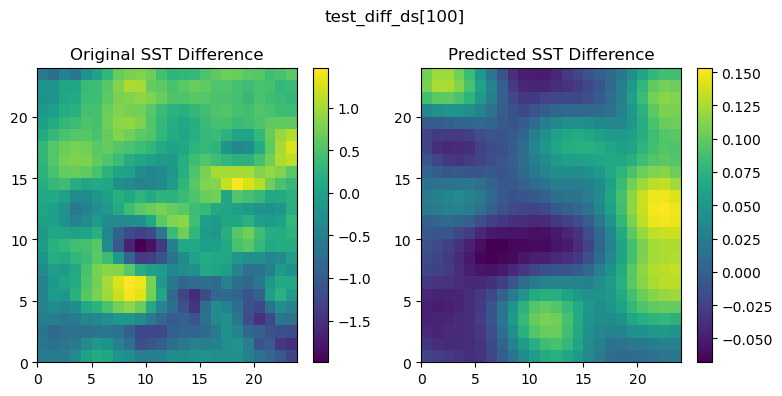

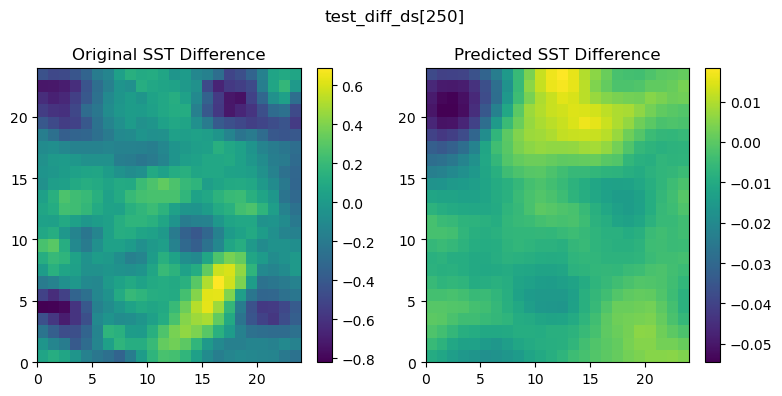

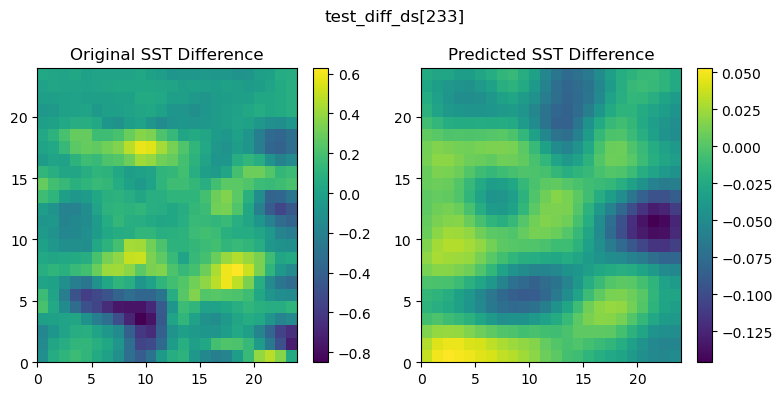

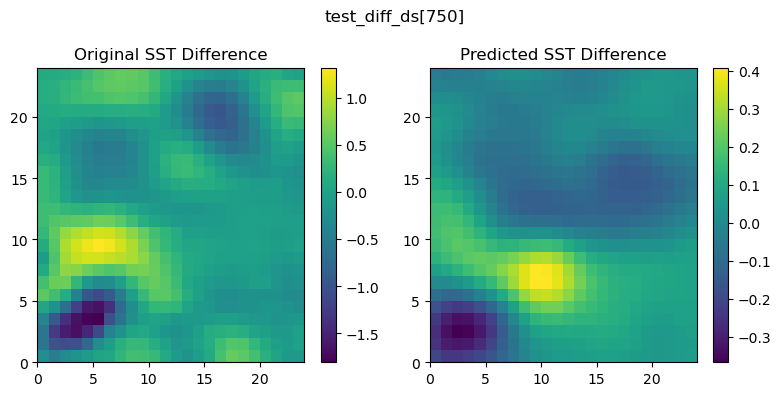

In [8]:
test_idx = [100, 250, 233, 750]
for idx in test_idx:
    X, y = test_diff_ds[idx]
    X = torch.tensor(X[None, ...]).to(device)
    y_pred = model(X).detach().cpu()

    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
    ax = axes[0]
    cs = ax.pcolormesh(y[0])
    fig.colorbar(cs, ax=ax)
    ax.set_title('Original SST Difference')

    ax = axes[1]
    cs = ax.pcolormesh(y_pred[0, 0])
    fig.colorbar(cs, ax=ax)
    ax.set_title('Predicted SST Difference')

    fig.suptitle(f'test_diff_ds[{idx}]')
    fig.tight_layout()

## Test MSE

In [9]:
model.eval()
test_dataloader = DataLoader(test_ds, batch_size=256, num_workers=4)
test_diff_dataloader = DataLoader(test_diff_ds, batch_size=256, num_workers=4)

diff_total_err = 0.
temp_total_err = 0.

with torch.no_grad():
    for (X_diff, y_diff), (X, y) in zip(test_diff_dataloader, test_dataloader):
        y_diff_pred = model(X_diff.to(device)).detach().cpu()

        # Calculate mse.
        diff_total_err += float(F.mse_loss(y_diff_pred, y_diff).item())

        # Convert to normal temperature.
        y_pred = X[:, -1:] + y_diff_pred
        temp_total_err += float(F.mse_loss(y_pred, y).item())

print(f'Difference error: {(diff_total_err / len(test_dataloader)):.4f}')
print(f'Temperature error: {(temp_total_err / len(test_dataloader)):.4f}')

Difference error: 0.3108
Temperature error: 0.3108


In [14]:
# Train difference error.
model.eval()
diff_total_err = 0.
temp_total_err = 0.

with torch.no_grad():
    for X_diff, y_diff in train_dataloader:
        y_diff_pred = model(X_diff.to(device)).detach().cpu()

        # Calculate mse.
        diff_total_err += float(F.mse_loss(y_diff_pred, y_diff).item())

print(f'Difference error: {(diff_total_err / len(train_dataloader)):.4f}')

Difference error: 0.0516


In [15]:
# Validation difference error.
model.eval()
diff_total_err = 0.
temp_total_err = 0.

with torch.no_grad():
    for X_diff, y_diff in val_dataloader:
        y_diff_pred = model(X_diff.to(device)).detach().cpu()

        # Calculate mse.
        diff_total_err += float(F.mse_loss(y_diff_pred, y_diff).item())

print(f'Difference error: {(diff_total_err / len(val_dataloader)):.4f}')

Difference error: 0.0753
